<a href="https://colab.research.google.com/github/gulabpatel/OCR/blob/main/08%3A%20Multi_column_OCR_HAC_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code walkthrough video: https://www.youtube.com/watch?v=Ai0Uj3Pw4vc&t=88s

https://pyimagesearch.com/2022/02/28/multi-column-table-ocr/

### Install the necessary packages

In [ ]:
!add-apt-repository -y ppa:alex-p/tesseract-ocr-devel
!apt-get update
!apt-get install tesseract-ocr
!pip install pytesseract

### Download the code zip file

In [ ]:
!wget "https://onedrive.live.com/download?cid=DBD24D3DC9712F7A&resid=DBD24D3DC9712F7A%2110213&authkey=AKAJrobqemGhan8" -O multi_column_data.zip
!unzip -qq multi_column_data.zip
%cd multi_column_data

In [ ]:
!wget https://github.com/doctorai-in/upload-images/raw/main/atevH.jpg

## Blog Post Code

### Import Packages

In [4]:
# import the necessary packages
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [5]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing Multi-Column Table OCR

In [6]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image to be OCR'd")
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output CSV file")
# ap.add_argument("-c", "--min-conf", type=int, default=0,
# 	help="minimum confidence value to filter weak text detection")
# ap.add_argument("-d", "--dist-thresh", type=float, default=25.0,
# 	help="distance threshold cutoff for clustering")
# ap.add_argument("-s", "--min-size", type=int, default=2,
# 	help="minimum cluster size (i.e., # of entries in column)")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values # michael_jordan_stats.png # atevH.jpg
args = {
	"image": "michael_jordan_stats.png",
	"output": "results.csv",
	"min_conf": 0,
	"dist_thresh": 25.0,
	"min_size": 2,
}

In [7]:
# set a seed for our random number generator
np.random.seed(42)

# load the input image and convert it to grayscale
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

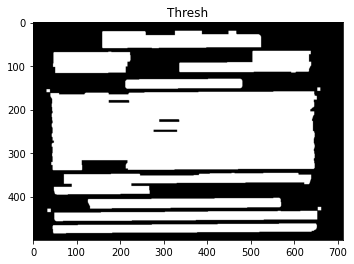

In [8]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# compute the Scharr gradient of the blackhat image and scale the result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

# apply a closing operation using the rectangular kernel to close gaps in between characters, 
#apply Otsu's thresholding method, and finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt_imshow("Thresh", thresh)

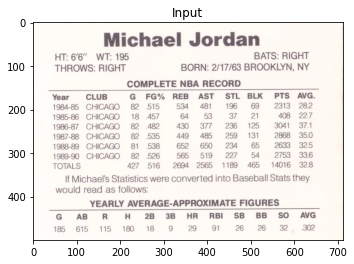

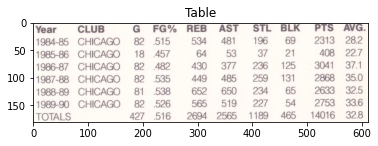

In [9]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)

# compute the bounding box coordinates of the stats table and extract
# the table from the input image
(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]

# show the original input image and extracted table to our screen
plt_imshow("Input", image)
plt_imshow("Table", table)

In [10]:
# Set the PSM mode to detect sparse text, and then localize text in the table
options = "--psm 6"
results = pytesseract.image_to_data(
	cv2.cvtColor(table, cv2.COLOR_BGR2RGB),
	config=options,
	output_type=Output.DICT)

# Initialize a list to store the (x, y)-coordinates of the detected text along with the OCR'd text itself
coords = []
ocrText = []

# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]

	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(float(results["conf"][i]))

	# filter out weak confidence text localizations
	if conf > args["min_conf"]:
		# update our text bounding box coordinates and OCR'd text,
		# respectively
		coords.append((x, y, w, h))
		ocrText.append(text)

In [11]:
# Extract all x-coordinates from the text bounding boxes, setting the y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]

# Apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
	n_clusters=None,
	affinity="manhattan",
	linkage="complete",
	distance_threshold=args["dist_thresh"])
clustering.fit(xCoords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=25.0,
                        linkage='complete', n_clusters=None)

In [12]:
# Initialize our list of sorted clusters
sortedClusters = []

# loop over all clusters
for l in np.unique(clustering.labels_):
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# verify that the cluster is sufficiently large
	if len(idxs) > args["min_size"]:
		# compute the average x-coordinate value of the cluster and
		# update our clusters list with the current label and the
		# average x-coordinate
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))

# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [13]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# extract the y-coordinates from the elements in the current
	# cluster, then sort them from top-to-bottom
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]

	# generate a random color for the cluster
	color = np.random.randint(0, 255, size=(3,), dtype="int")
	color = [int(c) for c in color]

	# loop over the sorted indexes
	for i in sortedIdxs:
		# extract the text bounding box coordinates and draw the
		# bounding box surrounding the current element
		(x, y, w, h) = coords[i]
		cv2.rectangle(table, (x, y), (x + w, y + h), color, 2)

	# extract the OCR'd text for the current column, then construct
	# a data frame for the data where the first entry in our column
	# serves as the header
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})

	# concatenate *original* data frame with the *current* data
	# frame (we do this to handle columns that may have a varying
	# number of rows)
	df = pd.concat([df, currentDF], axis=1)

### Multi-Column OCR results

In [14]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))

+----+---------+---------+-----+---------+--------+-------+-------+-------+-------+--------+
|    | Year    | CLUB    |   G |     FG% |    REB | AST   | STL   | BLK   |   PTS |   AVG. |
|----+---------+---------+-----+---------+--------+-------+-------+-------+-------+--------|
|  0 | 1984-85 | CHICAGO |  82 | 515     | 534481 | 53    | 196   | 69    |  2313 |  282   |
|  1 | 1985-86 | CHICAGO |  18 |   0.457 |     64 | 377   | wr    | A     |   408 |  227   |
|  2 | 1986-87 | CHICAGO |  82 | 482     |    430 | 485   | 236   | 125   |  3041 |   37.1 |
|  3 | 1987-88 | CHICAGO |  82 | 535     |    449 | 650   | 259   | 131   |  2868 |  635   |
|  4 | 1988-89 | CHICAGO |  81 | 538     |    652 | 519   | 234   | 65    |  2633 |  325   |
|  5 | 1989-90 | CHICAGO |  82 | 526     |    565 | 2565  | 227   | 54    |  2763 |   33.6 |
|  6 | TOTALS  |         | 427 | 516     |   2694 |       | 1189  | 465   | 14016 |  328   |
+----+---------+---------+-----+---------+--------+-------+-------+---

[INFO] saving CSV file to disk...


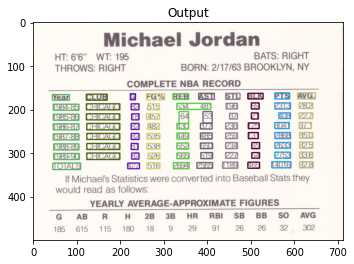

In [15]:
# write our table to disk as a CSV file
print("[INFO] saving CSV file to disk...")
df.to_csv(args["output"], index=False)

# show the output image after performing multi-column OCR
plt_imshow("Output", image)